<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/OCR_BACKSIDE_CROPPING_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your zip file on Google Drive
zip_file_path = '/content/drive/MyDrive/dataset .zip'  # Change this to the path of your zip file in Google Drive
unzip_dir = '/content/dataset'  # Directory where the dataset will be extracted

# Unzipping the dataset
import zipfile
import os

# Create directory to unzip the dataset
os.makedirs(unzip_dir, exist_ok=True)

# Unzip the dataset into the specified directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

print(f"Dataset unzipped successfully to {unzip_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset unzipped successfully to /content/dataset


In [34]:
# Mount Google Drive to save the model
from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import cv2
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
from torchvision import transforms

# Custom Dataset Class for full images and their cropped parts
class CustomProductDataset(Dataset):
    def __init__(self, full_image_dir, cropped_image_dir, transform=None):
        self.transform = transforms.Compose([
            transforms.Resize((640, 640)),  # Resize to a smaller size
            transforms.RandomHorizontalFlip(0.5),  # Augmentation: Random horizontal flip
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Augmentation: Random color jitter
            transforms.ToTensor(),
        ])
        self.full_image_dir = full_image_dir
        self.cropped_image_dir = cropped_image_dir
        # Filter out .DS_Store files from the image lists
        self.full_images = [f for f in sorted(os.listdir(self.full_image_dir)) if not f.startswith('.')]
        self.cropped_images = [f for f in sorted(os.listdir(self.cropped_image_dir)) if not f.startswith('.')]

        # Ensure both lists have the same length; if not, adjust to the minimum length
        min_len = min(len(self.full_images), len(self.cropped_images))
        self.full_images = self.full_images[:min_len]
        self.cropped_images = self.cropped_images[:min_len]
        print(f"Number of full images: {len(self.full_images)}")
        print(f"Number of cropped images: {len(self.cropped_images)}")

    def __getitem__(self, idx):
        full_img_path = os.path.join(self.full_image_dir, self.full_images[idx])
        cropped_img_path = os.path.join(self.cropped_image_dir, self.cropped_images[idx])

        full_img = Image.open(full_img_path).convert("RGB")
        cropped_img = Image.open(cropped_img_path).convert("RGB")

        # Get bounding box from the cropped image by comparing with the full image
        full_img_np = np.array(full_img)
        cropped_img_np = np.array(cropped_img)

        fh, fw, _ = full_img_np.shape
        ch, cw, _ = cropped_img_np.shape

        if ch > fh or cw > fw:
            # Resize the cropped image to be smaller than the full image
            scale_factor = min(fh / ch, fw / cw)
            new_ch = int(ch * scale_factor)
            new_cw = int(cw * scale_factor)
            cropped_img_np = cv2.resize(cropped_img_np, (new_cw, new_ch))

        # Use OpenCV template matching to find the cropped image within the full image
        result = cv2.matchTemplate(full_img_np, cropped_img_np, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)
        top_left = max_loc
        h, w, _ = cropped_img_np.shape
        bottom_right = (top_left[0] + w, top_left[1] + h)

        # Bounding box coordinates
        boxes = [[top_left[0], top_left[1], bottom_right[0], bottom_right[1]]]

        # Check for valid bounding box
        if boxes[0][2] <= boxes[0][0] or boxes[0][3] <= boxes[0][1]:
            raise ValueError(f"Invalid bounding box detected: {boxes}")

        # Create the target dictionary
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor([1], dtype=torch.int64)  # Class label for manufacturing date
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        if self.transform:
            full_img = self.transform(full_img)

        return full_img, target

    def __len__(self):
        return len(self.full_images)

# Learning rate warm-up function
def get_lr_lambda(warmup_iters, warmup_factor):
    def lr_lambda(epoch):
        if epoch < warmup_iters:
            alpha = float(epoch) / warmup_iters
            return warmup_factor * (1 - alpha) + alpha
        return 1.0
    return lr_lambda

# Load a pre-trained Faster R-CNN model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

# Function to train the model with dynamic learning rate adjustment and warm-up
def train_model(model, data_loader, device, optimizer, scheduler, scheduler_warmup, num_epochs=20, warmup_iters=500):
    model.train()
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs}")
        epoch_loss = 0
        for images, targets in data_loader:
            # Convert PIL Images to PyTorch tensors and move them to the device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            # Forward pass
            loss_dict = model(images, targets)

            # Sum losses from the loss dictionary
            losses = sum(loss for loss in loss_dict.values())

            # Check for NaN losses
            if torch.isnan(losses):
                print("NaN loss detected. Skipping this batch.")
                continue

            # Backward pass
            losses.backward()

            # Gradient Clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            optimizer.step()

            epoch_loss += losses.item()

            # Empty cache after each batch to free GPU memory
            torch.cuda.empty_cache()

        # Learning rate scheduler: Warm-up first, then Cosine Annealing
        if epoch < warmup_iters:
            scheduler_warmup.step()
        else:
            scheduler.step()

        # Print epoch loss
        print(f"Epoch Loss: {epoch_loss:.4f}")

# Main function for training
def main():
    # Define paths to dataset directories
    dataset_root = '/content/dataset/dataset '
    full_image_dir = os.path.join(dataset_root, 'full_images')
    cropped_image_dir = os.path.join(dataset_root, 'cropped_images')

    # Load dataset
    dataset = CustomProductDataset(full_image_dir, cropped_image_dir)
    data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

    # Set device (GPU if available)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Get the model with 2 classes (background and manufacturing date)
    model = get_model(num_classes=2)
    model.to(device)

    # Optimizer and learning rate scheduler with warm-up and cosine annealing
    optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)

    # Warm-up learning rate scheduler
    scheduler_warmup = LambdaLR(optimizer, lr_lambda=get_lr_lambda(500, 0.001))  # 500 steps for warm-up

    # Cosine annealing learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

    # Train the model for more epochs (e.g., 250 depending on your dataset size)
    train_model(model, data_loader, device, optimizer, scheduler, scheduler_warmup, num_epochs=250)

    # Save the model to Google Drive
    model_save_path = '/content/drive/MyDrive/faster_rcnn_product_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

if __name__ == "__main__":
    main()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of full images: 78
Number of cropped images: 78
Epoch: 1/250
Epoch Loss: 116.8456
Epoch: 2/250
Epoch Loss: 99.8292
Epoch: 3/250
Epoch Loss: 107.1342
Epoch: 4/250
Epoch Loss: 92.2580
Epoch: 5/250
Epoch Loss: 92.0482
Epoch: 6/250
Epoch Loss: 85.4877
Epoch: 7/250
Epoch Loss: 102.1679
Epoch: 8/250
Epoch Loss: 83.4981
Epoch: 9/250
Epoch Loss: 75.3759
Epoch: 10/250
Epoch Loss: 89.5693
Epoch: 11/250
Epoch Loss: 76.1702
Epoch: 12/250
Epoch Loss: 71.9725
Epoch: 13/250
Epoch Loss: 73.1336
Epoch: 14/250
Epoch Loss: 67.5252
Epoch: 15/250
Epoch Loss: 69.7581
Epoch: 16/250
Epoch Loss: 77.8983
Epoch: 17/250
Epoch Loss: 67.6545
Epoch: 18/250
Epoch Loss: 66.2494
Epoch: 19/250
Epoch Loss: 64.4882
Epoch: 20/250
Epoch Loss: 63.1632
Epoch: 21/250
Epoch Loss: 61.3747
Epoch: 22/250
Epoch Loss: 63.9034
Epoch: 23/250
Epoch Loss: 59.9974
Epoch: 24/250
Epoch Loss: 62.7389
Epoch:

<ipython-input-38-4fc58c416814>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


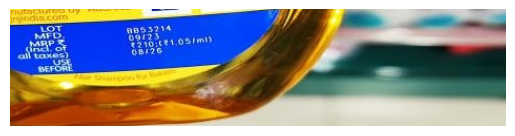

Cropped image saved to cropped_output.jpg


In [38]:
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained Faster R-CNN model with your trained weights
def load_model(model_path, num_classes=2):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    # Load the trained model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode
    return model

# Function to preprocess the user-provided image
def preprocess_image(image_path, img_size=(640, 640)):
    image = Image.open(image_path).convert("RGB")

    # Apply transformations (resize and convert to tensor)
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Function to apply the model to the image and get the cropped region
def get_cropped_image(model, image_tensor, original_image, device):
    # Move the image to the device (GPU or CPU)
    image_tensor = image_tensor.to(device)

    # Perform inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract the bounding box with the highest confidence score
    boxes = predictions[0]['boxes'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    # Filter based on confidence (e.g., threshold of 0.5)
    threshold = 0.01
    best_box = None
    for i, score in enumerate(scores):
        if score > threshold:
            best_box = boxes[i]
            break

    if best_box is None:
        print("No region detected with confidence above threshold.")
        return None

    # Crop the image using the bounding box
    xmin, ymin, xmax, ymax = map(int, best_box)

    # Convert original image to OpenCV format for cropping
    original_image_cv = cv2.cvtColor(np.array(original_image), cv2.COLOR_RGB2BGR)
    cropped_image = original_image_cv[ymin:ymax, xmin:xmax]

    return cropped_image

# Function to display the cropped image
def display_cropped_image(cropped_image):
    if cropped_image is not None:
        # Convert from OpenCV's BGR to RGB for display
        cropped_image_rgb = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
        plt.imshow(cropped_image_rgb)
        plt.axis('off')
        plt.show()
    else:
        print("No cropped image to display.")

# Main function to load the model, apply to the image, and get cropped output
def apply_model_to_image(model_path, image_path):
    # Load the model
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = load_model(model_path, num_classes=2).to(device)

    # Preprocess the input image
    original_image = Image.open(image_path).convert("RGB")  # Keep the original image for cropping
    image_tensor = preprocess_image(image_path)

    # Get the cropped image from the model's predictions
    cropped_image = get_cropped_image(model, image_tensor, original_image, device)

    # Display the cropped image
    display_cropped_image(cropped_image)

    # Optionally, save the cropped image
    if cropped_image is not None:
        output_path = "cropped_output.jpg"
        cv2.imwrite(output_path, cropped_image)
        print(f"Cropped image saved to {output_path}")

# Usage example:
model_path = '/content/drive/MyDrive/faster_rcnn_product_model.pth'  # Path to the trained model
image_path = '/content/27.jpg'  # Path to the user-provided image
apply_model_to_image(model_path, image_path)
